# Predicting the Football (Soccer) World Cup Winner with Machine Learning

**Aim:** to predict the outcome of the FIFA World Cup 2018

**Method:**

1. Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.
2. Use this model to predict the outcome of the group rounds and then the single-elimination phase

Summary According to the analysis below, the team that will win the World Cup is the underdog according to the bookies: Germany . But this is not the only interesting thing you can observe. If not interested in the data munging part head to the last section (Visualization) and see the single-elimination phase. To make the story more interesting for the sport lovers, I report fair odds (i.e. fair market, without bookmaker margin) instead of the raw probability output.


# Data I/O
Three datasets were used:

1. FIFA rankings from 1993 to 2018 - used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a decent predictor of team performance

2. International Soccer matches from 1872 to 2018 (courtesy of Mart Jürisoo) - to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match

3. FIFA World Cup 2018 data set (courtesy of Nuggs) -  to get the upcoming matches


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from matplotlib import pyplot as plt


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

In [6]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [7]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [8]:
world_cup.head()

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran


# 2. Feature extraction

We join the matches with the ranks of the different teams.

Then extract some features:

- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict

In [9]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
  
rankings.head()

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,2003-01-15,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
1,2003-01-16,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
2,2003-01-17,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
3,2003-01-18,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
4,2003-01-19,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0


### Adding Fifa Rankings to Match Data

In [10]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [11]:
# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0


In [12]:
# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,...,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,...,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0


In [13]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,...,0.0,0.0,0.0,0.0,-6.0,11.0,0.0,0,False,False
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,...,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,...,0.0,0.0,0.0,0.0,-21.0,75.5,0.0,1,True,False
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,...,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True


# 3. Modeling
I used a simple Logistic regression, which yielded already rather good performance

/Users/JISOO/Desktop/STAT3011-Group5-Project2/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.69      0.69      0.69      1908
        True       0.67      0.68      0.67      1788

    accuracy                           0.68      3696
   macro avg       0.68      0.68      0.68      3696
weighted avg       0.68      0.68      0.68      3696



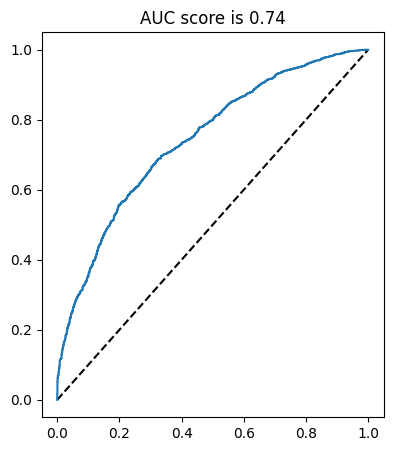

In [14]:
from sklearn import *
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Use a logistic Regression model
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. 

Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.575424
False    0.424576
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


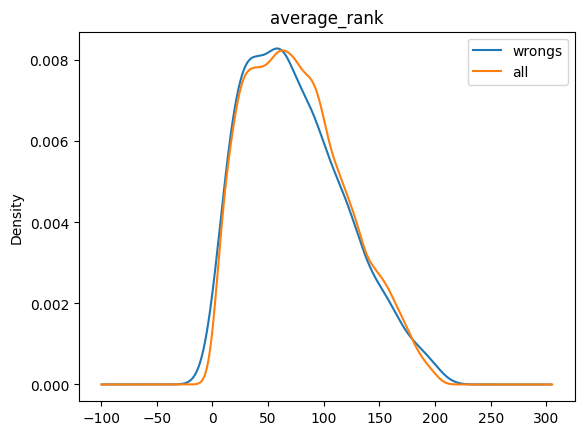

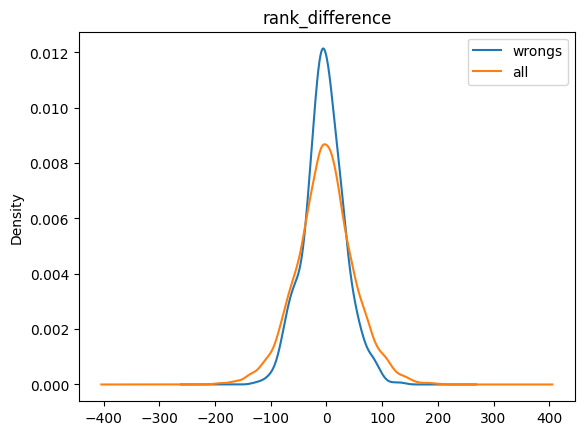

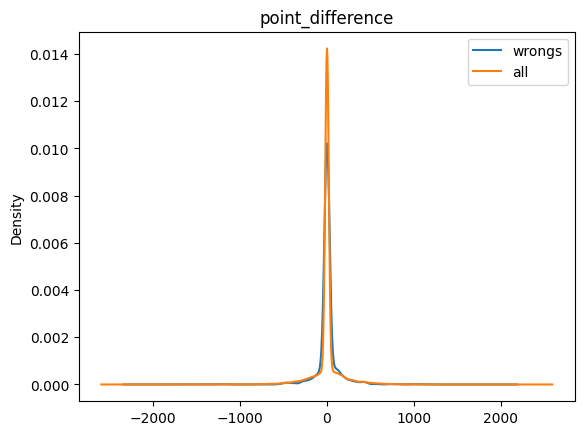

In [15]:
features = ['average_rank', 'rank_difference', 'point_difference']

# Get the wrongly predicted matches
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here) - fortunately, this implies that for the world cup our predicitons may be somewhat even better

# 4. World Cup simulation

In [16]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings.head()

,rank_date,rank,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
country_full,,,,,,,
Argentina,2018-06-07,5.0,ARG,404.07,248.99,183.59,836.65
Australia,2018-06-07,36.0,AUS,366.60,98.16,59.79,524.55
Belgium,2018-06-07,3.0,BEL,629.98,158.94,186.58,975.50
Brazil,2018-06-07,2.0,BRA,558.95,168.06,162.38,889.39
Colombia,2018-06-07,16.0,COL,292.09,199.73,166.38,658.20


In [17]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # get the prediction proability of the home team winning
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group F:___
Germany vs. Mexico: Germany wins with 0.61
Germany vs. Sweden: Germany wins with 0.63
Germany vs. Korea Republic: Germany wins with 0.65
Mexico vs. Sweden: Mexico wins with 0.54
Mexico vs. Korea Republic: Mexico wins with 0.65
Sweden vs. Korea Republic: Sweden wins with 0.61
___Starting group C:___
France vs. Australia: France wins with 0.63
France vs. Peru: Draw
France vs. Denmark: Draw
Australia vs. Peru: Peru wins with 0.66
Australia vs. Denmark: Denmark wins with 0.69
Peru vs. Denmark: Denmark wins with 0.54
___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins with 0.64
Russia vs. Uruguay: Uruguay wins with 0.80
Saudi Arabia vs. Egypt: Egypt wins with 0.63
Saudi Arabia vs. Uruguay: Uruguay wins with 0.80
Egypt vs. Uruguay: Uruguay wins with 0.72
___Starting group B:___
Portugal vs. Spain: Portugal wins with 0.54
Portugal vs. Morocco: Portugal wins with 0.66
Portugal vs. Iran: Portugal wins with 0.65
Spain 

# Single-elimination rounds

In [18]:
world_cup

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay,0,1.009257
Saudi Arabia,A,Russia,Uruguay,Egypt,3,1.125587
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.549673
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.315482
Portugal,B,Spain,Morocco,Iran,9,1.849718
Spain,B,Portugal,Iran,Morocco,6,1.712520
Morocco,B,Iran,Portugal,Spain,0,1.167155
Iran,B,Morocco,Spain,Portugal,3,1.270607
France,C,Australia,Peru,Denmark,5,1.634955


In [19]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.315482
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.549673
Spain,B,Portugal,Iran,Morocco,6,1.712520
Portugal,B,Spain,Morocco,Iran,9,1.849718
Denmark,C,Peru,Australia,France,7,1.750549
France,C,Australia,Peru,Denmark,5,1.634955
Croatia,D,Nigeria,Argentina,Iceland,4,1.543281
Argentina,D,Iceland,Croatia,Nigeria,9,1.853338
Brazil,E,Switzerland,Costa Rica,Serbia,9,1.800543


In [20]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = model.predict_proba(row)[:,1][0]
        
        # Display resultes
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.53
Denmark vs. Croatia: Denmark wins with probability 0.56
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.80
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.64
England vs. Poland: Poland wins with probability 0.52


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.52
Brazil vs. Belgium: Belgium wins with probability 0.52
Portugal vs. Argentina: Portugal wins with probability 0.52
Germany vs. Poland: Germany wins with probability 0.59


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.56
Portugal vs. Germany: Germany wins with probability 0.58


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.56




# Let's see a visualization

/var/folders/hm/f_2f7w212174qh26d8_r_npc0000gn/T/ipykernel_73538/3678938229.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


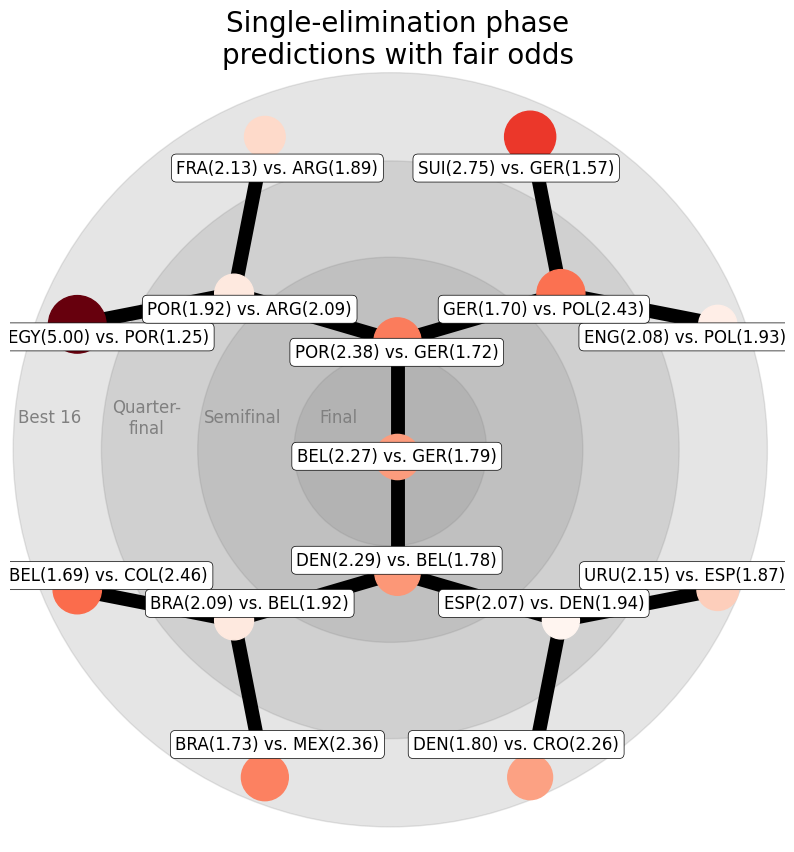

In [21]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()


# Improvement
## Random Forest Simulation

1. Import necessary libraries

# Actual Results to compare

![](https://i.imgur.com/h1uA9WV.png?1)